In [1]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage.color import rgb2grey
import cv2 as cv

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc

/home/saman/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/saman/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/saman/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/saman/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: Futu

In [2]:
matTr = loadmat('train_32x32.mat')
matTe = loadmat('test_32x32.mat')
# matExt = loadmat('extra_32x32.mat')

# labels are originally in [1,10] and now will be in [0,9]
Xtr, Ytr = matTr['X'], matTr['y']-1
Xte, Yte = matTe['X'], matTe['y']-1
# Xext, Yext = matExt['X'], matExt['y']-1

# changing the dimensions so that the number of the input image is the first
Xtr = np.transpose(Xtr, (3, 0, 1, 2))
Xte = np.transpose(Xte, (3, 0, 1, 2))
# Xext = np.transpose(Xext, (3, 0, 1, 2))

# Xtr_ext = np.concatenate((Xtr,Xext))
# Ytr_ext = np.concatenate((Ytr,Yext))
Xtr, Xte = Xtr / 255.0, Xte / 255.0
# Xtr_ext = Xtr_ext / 255.0
Ytr = np.squeeze(Ytr)
Yte = np.squeeze(Yte)
# Yext = np.squeeze(Yext)

In [ ]:
# Xtr_gray = np.zeros((len(Xtr),32,32,1))
# for i in range(len(Xtr)):
#     Xtr_gray[i] = tf.image.rgb_to_grayscale(Xtr[i])
Xtr_gray = tf.image.rgb_to_grayscale(Xtr)


In [ ]:
Xtr_gray = K.eval(Xtr_gray)

In [ ]:
Xtr_bin = np.zeros((len(Xtr_gray),32,32,1))
for i in range(len(Xtr_gray)):
    Xtr_bin[i,:,:,0] = cv.adaptiveThreshold(Xtr_gray[i,:,:,0],255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,11,2)
#     blur = cv.GaussianBlur(Xtr_gray[i,:,:,0],(5,5),0)
#     _, Xtr_bin[i,:,:,0] = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

```python
ind = 700
titles = ['RGB Image', 'GRAY_SCALE', 'BINARY']
images = [Xtr[ind], Xtr_gray[ind,:,:,0], Xtr_bin[ind,:,:,0]]
for i in range(3):
    plt.subplot(1,3,i+1)
    if i!=0:
        plt.imshow(images[i],'gray')
    else:
        plt.imshow(images[i])
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.savefig('images.png',bbox_inches = 'tight')
plt.show()
```

```python
plt.hist(Ytr, ec='k',bins=10)
plt.title('Histogram of Train Data')
plt.savefig('histogram.png',bbox_inches = 'tight')
```

# Experiment 1

In [5]:
epochs=20
nets = 3
model = [0]*nets
history = [0]*nets
for i in range(nets):
    model[i] = Sequential()
    model[i].add(Conv2D(16, kernel_size=5, activation='relu', padding="same", input_shape=(32,32,3)))
    model[i].add(MaxPooling2D())
    if i>0:
        model[i].add(Conv2D(32, kernel_size=5, activation='relu', padding="same"))
        model[i].add(MaxPooling2D())
    if i>1:
        model[i].add(Conv2D(64, kernel_size=5, activation='relu', padding="same"))
        model[i].add(MaxPooling2D(padding='same'))
    model[i].add(Flatten())
    model[i].add(Dense(256, activation='relu'))
    model[i].add(Dense(10, activation='softmax'))
    model[i].compile(optimizer='adam',
                  loss=tf.keras.losses.sparse_categorical_crossentropy,
                  metrics=['accuracy'])
    
X_train2, X_val2, Y_train2, Y_val2 = train_test_split(Xtr, Ytr, test_size = 0.1)
for j in range(nets):
    history[j] = model[j].fit(X_train2, Y_train2, epochs=epochs, batch_size=64,
                              validation_data = (X_val2, Y_val2), verbose=2)
    print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
            j+1,epochs,max(history[j].history['acc']),max(history[j].history['val_acc']) ))

Train on 65931 samples, validate on 7326 samples
Epoch 1/20
 - 3s - loss: 1.2699 - acc: 0.5932 - val_loss: 0.8174 - val_acc: 0.7491
Epoch 2/20
 - 3s - loss: 0.6602 - acc: 0.8076 - val_loss: 0.5995 - val_acc: 0.8269
Epoch 3/20
 - 2s - loss: 0.5568 - acc: 0.8396 - val_loss: 0.5715 - val_acc: 0.8378
Epoch 4/20
 - 3s - loss: 0.5007 - acc: 0.8560 - val_loss: 0.5296 - val_acc: 0.8518
Epoch 5/20
 - 3s - loss: 0.4558 - acc: 0.8686 - val_loss: 0.4908 - val_acc: 0.8632
Epoch 6/20
 - 2s - loss: 0.4235 - acc: 0.8777 - val_loss: 0.5046 - val_acc: 0.8598
Epoch 7/20
 - 3s - loss: 0.3913 - acc: 0.8866 - val_loss: 0.4723 - val_acc: 0.8718
Epoch 8/20
 - 3s - loss: 0.3617 - acc: 0.8939 - val_loss: 0.5094 - val_acc: 0.8580
Epoch 9/20
 - 2s - loss: 0.3359 - acc: 0.9006 - val_loss: 0.4952 - val_acc: 0.8621
Epoch 10/20
 - 2s - loss: 0.3119 - acc: 0.9077 - val_loss: 0.4884 - val_acc: 0.8668
Epoch 11/20
 - 2s - loss: 0.2854 - acc: 0.9159 - val_loss: 0.4801 - val_acc: 0.8676
Epoch 12/20
 - 2s - loss: 0.2630 - a

In [6]:
epochs=20
for j in range(3):
    print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
            j+1,epochs,max(history[j].history['acc']),max(history[j].history['val_acc']) ))

CNN 1: Epochs=20, Train accuracy=0.95553, Validation accuracy=0.87319
CNN 2: Epochs=20, Train accuracy=0.98787, Validation accuracy=0.90677
CNN 3: Epochs=20, Train accuracy=0.98471, Validation accuracy=0.91127


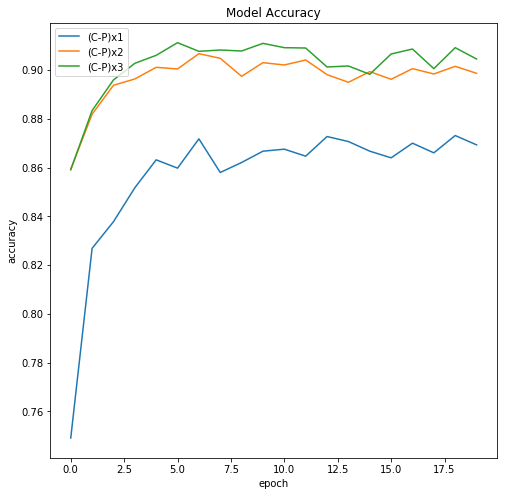

In [9]:
plt.figure(figsize=(8, 8))
for i in range(nets):
    val_acc = history[i].history['val_acc']
    epochs_range = range(epochs)
    plt.plot(epochs_range, val_acc, label='(C-P)x{}'.format(i+1))
    
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Model Accuracy')
plt.legend(loc='lower left')
plt.show()

# Experiment 2

In [10]:
epochs=20
nets = 6
model = [0]*nets
history = [0]*nets
for i in range(nets):
    model[i] = Sequential()
    model[i].add(Conv2D(i*8+8, kernel_size=5, activation='relu', padding="same", input_shape=(32,32,3)))
    model[i].add(MaxPooling2D())
    model[i].add(Conv2D(i*16+16, kernel_size=5, activation='relu', padding="same"))
    model[i].add(MaxPooling2D())
    model[i].add(Flatten())
    model[i].add(Dense(256, activation='relu'))
    model[i].add(Dense(10, activation='softmax'))
    model[i].compile(optimizer='adam',
                  loss=tf.keras.losses.sparse_categorical_crossentropy,
                  metrics=['accuracy'])
    
X_train2, X_val2, Y_train2, Y_val2 = train_test_split(Xtr, Ytr, test_size = 0.1)
for j in range(nets):
    history[j] = model[j].fit(X_train2, Y_train2, epochs=20, batch_size=64,
                              validation_data = (X_val2, Y_val2), verbose=2)
    print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
            j+1,epochs,max(history[j].history['acc']),max(history[j].history['val_acc']) ))

Train on 65931 samples, validate on 7326 samples
Epoch 1/20
 - 3s - loss: 0.9777 - acc: 0.6914 - val_loss: 0.5597 - val_acc: 0.8415
Epoch 2/20
 - 2s - loss: 0.4688 - acc: 0.8650 - val_loss: 0.4661 - val_acc: 0.8645
Epoch 3/20
 - 2s - loss: 0.3884 - acc: 0.8860 - val_loss: 0.4132 - val_acc: 0.8777
Epoch 4/20
 - 2s - loss: 0.3343 - acc: 0.9022 - val_loss: 0.3944 - val_acc: 0.8879
Epoch 5/20
 - 2s - loss: 0.2926 - acc: 0.9152 - val_loss: 0.4038 - val_acc: 0.8856
Epoch 6/20
 - 2s - loss: 0.2567 - acc: 0.9238 - val_loss: 0.3870 - val_acc: 0.8915
Epoch 7/20
 - 2s - loss: 0.2243 - acc: 0.9337 - val_loss: 0.4519 - val_acc: 0.8853
Epoch 8/20
 - 2s - loss: 0.1989 - acc: 0.9408 - val_loss: 0.4212 - val_acc: 0.8885
Epoch 9/20
 - 2s - loss: 0.1739 - acc: 0.9476 - val_loss: 0.4380 - val_acc: 0.8923
Epoch 10/20
 - 2s - loss: 0.1511 - acc: 0.9547 - val_loss: 0.4619 - val_acc: 0.8927
Epoch 11/20
 - 2s - loss: 0.1307 - acc: 0.9612 - val_loss: 0.4524 - val_acc: 0.8920
Epoch 12/20
 - 2s - loss: 0.1154 - a

Epoch 13/20
 - 4s - loss: 0.0950 - acc: 0.9710 - val_loss: 0.5342 - val_acc: 0.8894
Epoch 14/20
 - 4s - loss: 0.0848 - acc: 0.9743 - val_loss: 0.5824 - val_acc: 0.8874
Epoch 15/20
 - 4s - loss: 0.0766 - acc: 0.9768 - val_loss: 0.5865 - val_acc: 0.8857
Epoch 16/20
 - 4s - loss: 0.0725 - acc: 0.9781 - val_loss: 0.6474 - val_acc: 0.8870
Epoch 17/20
 - 4s - loss: 0.0660 - acc: 0.9797 - val_loss: 0.6468 - val_acc: 0.8938
Epoch 18/20
 - 4s - loss: 0.0613 - acc: 0.9811 - val_loss: 0.6817 - val_acc: 0.8933
Epoch 19/20
 - 4s - loss: 0.0516 - acc: 0.9843 - val_loss: 0.6946 - val_acc: 0.8873
Epoch 20/20
 - 4s - loss: 0.0567 - acc: 0.9827 - val_loss: 0.6967 - val_acc: 0.8871
CNN 5: Epochs=20, Train accuracy=0.98427, Validation accuracy=0.89640
Train on 65931 samples, validate on 7326 samples
Epoch 1/20
 - 5s - loss: 0.9224 - acc: 0.7077 - val_loss: 0.5132 - val_acc: 0.8535
Epoch 2/20
 - 5s - loss: 0.4325 - acc: 0.8767 - val_loss: 0.4310 - val_acc: 0.8743
Epoch 3/20
 - 4s - loss: 0.3513 - acc: 0.89

In [11]:
epochs=20
for j in range(nets):
    print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
            j+1,epochs,max(history[j].history['acc']),max(history[j].history['val_acc']) ))

CNN 1: Epochs=20, Train accuracy=0.98438, Validation accuracy=0.89271
CNN 2: Epochs=20, Train accuracy=0.98814, Validation accuracy=0.90199
CNN 3: Epochs=20, Train accuracy=0.98781, Validation accuracy=0.90227
CNN 4: Epochs=20, Train accuracy=0.98737, Validation accuracy=0.90254
CNN 5: Epochs=20, Train accuracy=0.98427, Validation accuracy=0.89640
CNN 6: Epochs=20, Train accuracy=0.98949, Validation accuracy=0.89667


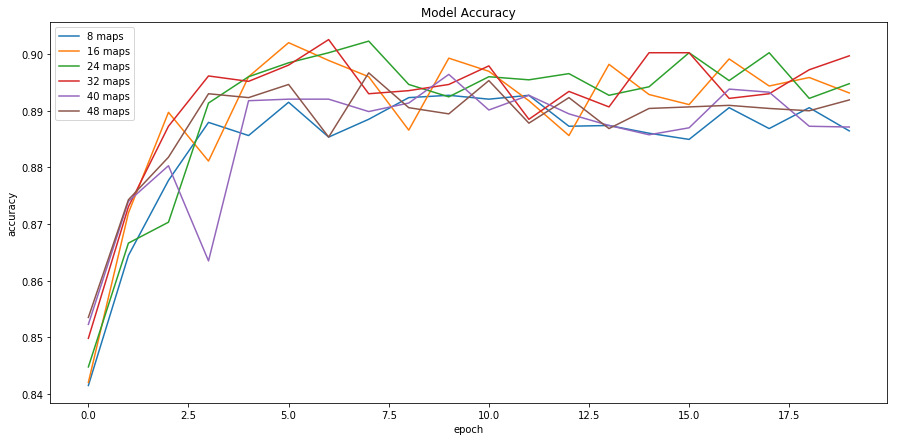

In [14]:
plt.figure(figsize=(15, 7))
for i in range(nets):
    val_acc = history[i].history['val_acc']
    epochs_range = range(epochs)

    
    plt.plot(epochs_range, val_acc, label='{} maps'.format(i*8+8))
    
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Model Accuracy')
plt.legend(loc='upper left')
plt.show()

# Experiment 3

In [15]:
epochs=20
nets = 8
model = [0]*nets
history = [0]*nets
for i in range(nets):
    model[i] = Sequential()
    model[i].add(Conv2D(32, kernel_size=5, activation='relu', padding="same", input_shape=(32,32,3)))
    model[i].add(MaxPooling2D())
    model[i].add(Conv2D(64, kernel_size=5, activation='relu', padding="same"))
    model[i].add(MaxPooling2D())
    model[i].add(Flatten())
    if i>0:
        model[i].add(Dense(2**(i+4), activation='relu'))
    model[i].add(Dense(10, activation='softmax'))
    model[i].compile(optimizer='adam',
                  loss=tf.keras.losses.sparse_categorical_crossentropy,
                  metrics=['accuracy'])
    
X_train2, X_val2, Y_train2, Y_val2 = train_test_split(Xtr, Ytr, test_size = 0.1)
for j in range(nets):
    history[j] = model[j].fit(X_train2, Y_train2, epochs=20, batch_size=64,
                              validation_data = (X_val2, Y_val2), verbose=2)
    print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
            j+1,epochs,max(history[j].history['acc']),max(history[j].history['val_acc']) ))

Train on 65931 samples, validate on 7326 samples
Epoch 1/20
 - 4s - loss: 0.8986 - acc: 0.7210 - val_loss: 0.5621 - val_acc: 0.8473
Epoch 2/20
 - 3s - loss: 0.4806 - acc: 0.8657 - val_loss: 0.4890 - val_acc: 0.8602
Epoch 3/20
 - 3s - loss: 0.4130 - acc: 0.8829 - val_loss: 0.4318 - val_acc: 0.8739
Epoch 4/20
 - 3s - loss: 0.3786 - acc: 0.8920 - val_loss: 0.4098 - val_acc: 0.8832
Epoch 5/20
 - 3s - loss: 0.3496 - acc: 0.9002 - val_loss: 0.4013 - val_acc: 0.8873
Epoch 6/20
 - 3s - loss: 0.3259 - acc: 0.9056 - val_loss: 0.3998 - val_acc: 0.8881
Epoch 7/20
 - 3s - loss: 0.3087 - acc: 0.9116 - val_loss: 0.3901 - val_acc: 0.8911
Epoch 8/20
 - 3s - loss: 0.2912 - acc: 0.9166 - val_loss: 0.4066 - val_acc: 0.8848
Epoch 9/20
 - 3s - loss: 0.2758 - acc: 0.9209 - val_loss: 0.3948 - val_acc: 0.8945
Epoch 10/20
 - 3s - loss: 0.2643 - acc: 0.9241 - val_loss: 0.3917 - val_acc: 0.8928
Epoch 11/20
 - 3s - loss: 0.2536 - acc: 0.9268 - val_loss: 0.4153 - val_acc: 0.8897
Epoch 12/20
 - 3s - loss: 0.2409 - a

Epoch 13/20
 - 4s - loss: 0.0581 - acc: 0.9830 - val_loss: 0.6044 - val_acc: 0.8991
Epoch 14/20
 - 4s - loss: 0.0481 - acc: 0.9858 - val_loss: 0.6249 - val_acc: 0.8954
Epoch 15/20
 - 4s - loss: 0.0473 - acc: 0.9860 - val_loss: 0.6629 - val_acc: 0.8974
Epoch 16/20
 - 4s - loss: 0.0483 - acc: 0.9858 - val_loss: 0.6582 - val_acc: 0.9023
Epoch 17/20
 - 4s - loss: 0.0408 - acc: 0.9884 - val_loss: 0.6875 - val_acc: 0.8995
Epoch 18/20
 - 4s - loss: 0.0438 - acc: 0.9877 - val_loss: 0.6646 - val_acc: 0.8982
Epoch 19/20
 - 4s - loss: 0.0417 - acc: 0.9889 - val_loss: 0.7716 - val_acc: 0.8901
Epoch 20/20
 - 4s - loss: 0.0409 - acc: 0.9891 - val_loss: 0.7005 - val_acc: 0.8991
CNN 5: Epochs=20, Train accuracy=0.98906, Validation accuracy=0.90227
Train on 65931 samples, validate on 7326 samples
Epoch 1/20
 - 5s - loss: 0.8468 - acc: 0.7301 - val_loss: 0.4615 - val_acc: 0.8666
Epoch 2/20
 - 4s - loss: 0.3944 - acc: 0.8841 - val_loss: 0.3958 - val_acc: 0.8867
Epoch 3/20
 - 4s - loss: 0.3108 - acc: 0.90

In [16]:
epochs=20
for j in range(nets):
    print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
            j+1,epochs,max(history[j].history['acc']),max(history[j].history['val_acc']) ))

CNN 1: Epochs=20, Train accuracy=0.94690, Validation accuracy=0.89449
CNN 2: Epochs=20, Train accuracy=0.93589, Validation accuracy=0.89080
CNN 3: Epochs=20, Train accuracy=0.95652, Validation accuracy=0.90022
CNN 4: Epochs=20, Train accuracy=0.98110, Validation accuracy=0.90063
CNN 5: Epochs=20, Train accuracy=0.98906, Validation accuracy=0.90227
CNN 6: Epochs=20, Train accuracy=0.99248, Validation accuracy=0.90704
CNN 7: Epochs=20, Train accuracy=0.98991, Validation accuracy=0.90390
CNN 8: Epochs=20, Train accuracy=0.99193, Validation accuracy=0.90923


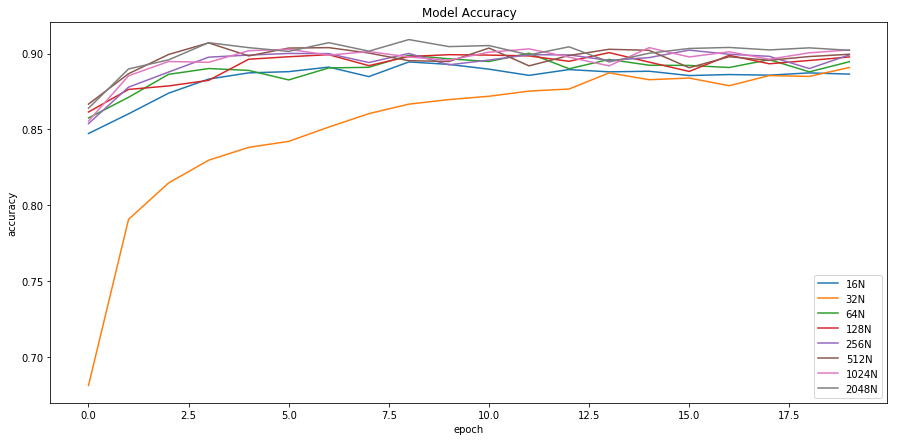

In [22]:
plt.figure(figsize=(15, 7))
for i in range(nets):
    val_acc = history[i].history['val_acc']
    epochs_range = range(epochs)

    plt.plot(epochs_range, val_acc, label='{}N'.format(2**(i+4)))

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Model Accuracy')
plt.legend(loc='lower right')
plt.savefig('experiment_3.png', bbox_inches='tight',dpi=300)
plt.show()

# Experiment 4

In [23]:
epochs=20
nets = 8
model = [0]*nets
history = [0]*nets
for i in range(nets):
    model[i] = Sequential()
    model[i].add(Conv2D(32, kernel_size=5, activation='relu', padding="same", input_shape=(32,32,3)))
    model[i].add(MaxPooling2D())
    model[i].add(Dropout(i*0.1))
    model[i].add(Conv2D(64, kernel_size=5, activation='relu', padding="same"))
    model[i].add(MaxPooling2D())
    model[i].add(Dropout(i*0.1))
    model[i].add(Flatten())
    model[i].add(Dense(512, activation='relu'))
    model[i].add(Dropout(i*0.1))
    model[i].add(Dense(10, activation='softmax'))
    model[i].compile(optimizer='adam',
                  loss=tf.keras.losses.sparse_categorical_crossentropy,
                  metrics=['accuracy'])
    
X_train2, X_val2, Y_train2, Y_val2 = train_test_split(Xtr, Ytr, test_size = 0.1)
for j in range(nets):
    history[j] = model[j].fit(X_train2, Y_train2, epochs=20, batch_size=64,
                              validation_data = (X_val2, Y_val2), verbose=2)
    print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
            j+1,epochs,max(history[j].history['acc']),max(history[j].history['val_acc']) ))

Train on 65931 samples, validate on 7326 samples
Epoch 1/20
 - 6s - loss: 0.8611 - acc: 0.7266 - val_loss: 0.4802 - val_acc: 0.8580
Epoch 2/20
 - 4s - loss: 0.4125 - acc: 0.8793 - val_loss: 0.3981 - val_acc: 0.8853
Epoch 3/20
 - 4s - loss: 0.3290 - acc: 0.9022 - val_loss: 0.3757 - val_acc: 0.8923
Epoch 4/20
 - 4s - loss: 0.2709 - acc: 0.9207 - val_loss: 0.3813 - val_acc: 0.8941
Epoch 5/20
 - 4s - loss: 0.2233 - acc: 0.9335 - val_loss: 0.3562 - val_acc: 0.9032
Epoch 6/20
 - 4s - loss: 0.1801 - acc: 0.9473 - val_loss: 0.3858 - val_acc: 0.8983
Epoch 7/20
 - 4s - loss: 0.1456 - acc: 0.9564 - val_loss: 0.3769 - val_acc: 0.9032
Epoch 8/20
 - 4s - loss: 0.1138 - acc: 0.9667 - val_loss: 0.4366 - val_acc: 0.8952
Epoch 9/20
 - 4s - loss: 0.0929 - acc: 0.9724 - val_loss: 0.4599 - val_acc: 0.8946
Epoch 10/20
 - 4s - loss: 0.0791 - acc: 0.9758 - val_loss: 0.4944 - val_acc: 0.8945
Epoch 11/20
 - 4s - loss: 0.0622 - acc: 0.9812 - val_loss: 0.5262 - val_acc: 0.9010
Epoch 12/20
 - 4s - loss: 0.0571 - a

Epoch 13/20
 - 4s - loss: 0.3822 - acc: 0.8824 - val_loss: 0.3144 - val_acc: 0.9094
Epoch 14/20
 - 4s - loss: 0.3672 - acc: 0.8873 - val_loss: 0.3180 - val_acc: 0.9075
Epoch 15/20
 - 4s - loss: 0.3577 - acc: 0.8883 - val_loss: 0.3098 - val_acc: 0.9110
Epoch 16/20
 - 4s - loss: 0.3546 - acc: 0.8886 - val_loss: 0.3093 - val_acc: 0.9130
Epoch 17/20
 - 4s - loss: 0.3560 - acc: 0.8893 - val_loss: 0.3170 - val_acc: 0.9070
Epoch 18/20
 - 4s - loss: 0.3451 - acc: 0.8914 - val_loss: 0.3032 - val_acc: 0.9133
Epoch 19/20
 - 4s - loss: 0.3397 - acc: 0.8939 - val_loss: 0.3022 - val_acc: 0.9143
Epoch 20/20
 - 4s - loss: 0.3386 - acc: 0.8939 - val_loss: 0.3050 - val_acc: 0.9120
CNN 5: Epochs=20, Train accuracy=0.89392, Validation accuracy=0.91428
Train on 65931 samples, validate on 7326 samples
Epoch 1/20
 - 6s - loss: 1.3519 - acc: 0.5450 - val_loss: 0.6101 - val_acc: 0.8271
Epoch 2/20
 - 4s - loss: 0.7425 - acc: 0.7664 - val_loss: 0.5383 - val_acc: 0.8519
Epoch 3/20
 - 5s - loss: 0.6522 - acc: 0.79

In [24]:
epochs=20
for j in range(nets):
    print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
            j+1,epochs,max(history[j].history['acc']),max(history[j].history['val_acc']) ))

CNN 1: Epochs=20, Train accuracy=0.99029, Validation accuracy=0.90322
CNN 2: Epochs=20, Train accuracy=0.97205, Validation accuracy=0.91018
CNN 3: Epochs=20, Train accuracy=0.95507, Validation accuracy=0.91673
CNN 4: Epochs=20, Train accuracy=0.92486, Validation accuracy=0.91878
CNN 5: Epochs=20, Train accuracy=0.89392, Validation accuracy=0.91428
CNN 6: Epochs=20, Train accuracy=0.85715, Validation accuracy=0.90418
CNN 7: Epochs=20, Train accuracy=0.78010, Validation accuracy=0.86896
CNN 8: Epochs=20, Train accuracy=0.51505, Validation accuracy=0.34767


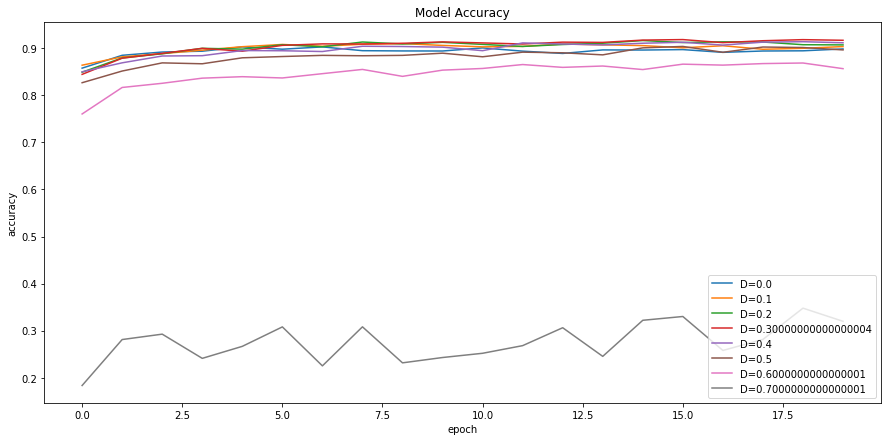

In [25]:
plt.figure(figsize=(15, 7))
for i in range(nets):
    val_acc = history[i].history['val_acc']
    epochs_range = range(epochs)

    
    plt.plot(epochs_range, val_acc, label='D={}'.format(i*0.1))

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Model Accuracy')
plt.legend(loc='lower right')
plt.savefig('experiment_4.png', bbox_inches='tight',dpi=300)
plt.show()

# Experiment 5

In [27]:
epochs=20
model = Sequential()
model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(32,32,3)))
model.add(BatchNormalization())
model.add(Conv2D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])
epochs = 20
X_train2, X_val2, Y_train2, Y_val2 = train_test_split(Xtr, Ytr, test_size = 0.1)
history = model.fit(X_train2, Y_train2, epochs=20, batch_size=64,
                              validation_data = (X_val2, Y_val2), verbose=2)


Train on 65931 samples, validate on 7326 samples
Epoch 1/20
 - 11s - loss: 0.8503 - acc: 0.7434 - val_loss: 0.3933 - val_acc: 0.8777
Epoch 2/20
 - 8s - loss: 0.4055 - acc: 0.8778 - val_loss: 0.3470 - val_acc: 0.8948
Epoch 3/20
 - 8s - loss: 0.3424 - acc: 0.8977 - val_loss: 0.2840 - val_acc: 0.9143
Epoch 4/20
 - 9s - loss: 0.3046 - acc: 0.9090 - val_loss: 0.2795 - val_acc: 0.9143
Epoch 5/20
 - 9s - loss: 0.2802 - acc: 0.9160 - val_loss: 0.2405 - val_acc: 0.9282
Epoch 6/20
 - 8s - loss: 0.2568 - acc: 0.9242 - val_loss: 0.2968 - val_acc: 0.9080
Epoch 7/20
 - 8s - loss: 0.2396 - acc: 0.9292 - val_loss: 0.2194 - val_acc: 0.9363
Epoch 8/20
 - 8s - loss: 0.2251 - acc: 0.9326 - val_loss: 0.2302 - val_acc: 0.9349
Epoch 9/20
 - 8s - loss: 0.2094 - acc: 0.9367 - val_loss: 0.2299 - val_acc: 0.9331
Epoch 10/20
 - 8s - loss: 0.1996 - acc: 0.9404 - val_loss: 0.2090 - val_acc: 0.9395
Epoch 11/20
 - 9s - loss: 0.1893 - acc: 0.9444 - val_loss: 0.2283 - val_acc: 0.9348
Epoch 12/20
 - 9s - loss: 0.1800 - 

In [30]:
print("CNN: Epochs={0:d}, Train accuracy={1:.5f}, Validation accuracy={2:.5f}".format(
            epochs,max(history.history['acc']),max(history.history['val_acc']) ))

CNN: Epochs=20, Train accuracy=0.96231, Validation accuracy=0.94458


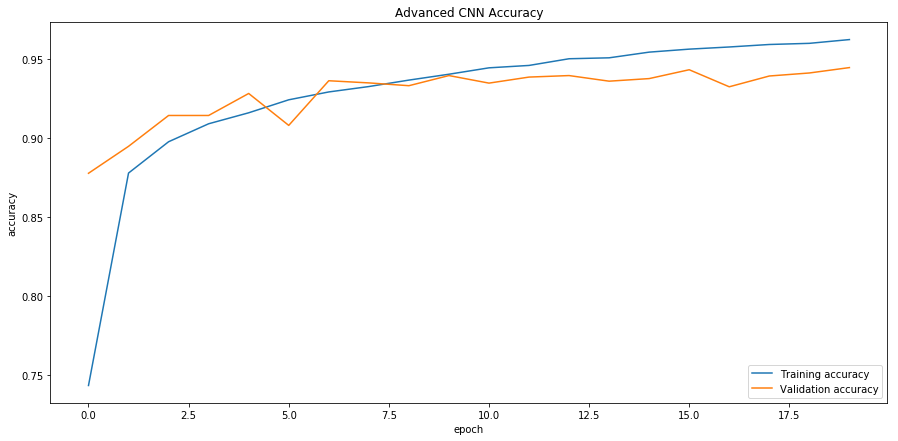

In [32]:
plt.figure(figsize=(15, 7))
acc = history.history['acc']

epochs_range = range(epochs)

plt.plot(epochs_range,acc, label='Training accuracy')
plt.plot(epochs_range, val_acc, label='Validation accuracy')

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Advanced CNN Accuracy')
plt.legend(loc='lower right')
plt.savefig('experiment_5.png', bbox_inches='tight',dpi=300)
plt.show()

# ML model

In [ ]:
def create_features(img):
    # flatten three channel color image
    color_features = img.flatten()
    # convert image to greyscale
    grey_image = rgb2grey(img)
    # get HOG features from greyscale image
    hog_features, _ = hog(img, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)
    # combine color and hog features into a single array
    flat_features = np.hstack((color_features,hog_features))
    return hog_features

In [ ]:
features_list = []
for i in range(len(Xtr)):
    image_features = create_features(Xtr[i])
    features_list.append(image_features)  
# convert list of arrays into a matrix
feature_matrix = np.array(features_list)


In [ ]:
feature_matrix.shape

In [ ]:
# scaling the features
from sklearn.preprocessing import scale
X_scaled = scale(feature_matrix)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Ytr, test_size = 0.3, train_size = 0.2 ,random_state = 10)

In [ ]:

model_linear = SVC(kernel='linear')
model_linear.fit(X_train, y_train)

# predict
y_pred = model_linear.predict(X_test)

In [ ]:
# confusion matrix and accuracy

from sklearn import metrics
from sklearn.metrics import confusion_matrix
# accuracy
print("accuracy:", metrics.accuracy_score(y_true=y_test, y_pred=y_pred), "\n")

# cm
print(metrics.confusion_matrix(y_true=y_test, y_pred=y_pred))